# Pneumonia Detection

## Initiate Random State

In [1]:
from numpy.random import seed
seed(42)
import tensorflow
tensorflow.random.set_seed(42)

## Download Data

In [2]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

In [4]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [5]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets list

ref                                                           title                                              size  lastUpdated          downloadCount  
------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                   Reddit Vaccine Myths                              233KB  2021-07-03 10:55:28           8757  
crowww/a-large-scale-fish-dataset                             A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           5354  
imsparsh/musicnet-dataset                                     MusicNet Dataset                                   22GB  2021-02-18 14:12:19           1898  
dhruvildave/wikibooks-dataset                                 Wikibooks Dataset                                   2GB  2021-07-03 18:37:20           2340  
promptcloud/careerbuilder-job-listing-2020                    Ca

In [7]:
!kaggle datasets download -d wilhelmberghammer/chest-xrays-pneumonia-detection

 99% 1.01G/1.02G [00:12<00:00, 54.5MB/s]
100% 1.02G/1.02G [00:12<00:00, 87.8MB/s]


## Extract Data

In [8]:
!unzip '/content/chest-xrays-pneumonia-detection.zip' -d '/tmp'

Archive:  /content/chest-xrays-pneumonia-detection.zip
  inflating: /tmp/data/test/BAC_PNEUMONIA/person100_bacteria_475.jpeg  
  inflating: /tmp/data/test/BAC_PNEUMONIA/person100_bacteria_477.jpeg  
  inflating: /tmp/data/test/BAC_PNEUMONIA/person100_bacteria_478.jpeg  
  inflating: /tmp/data/test/BAC_PNEUMONIA/person100_bacteria_479.jpeg  
  inflating: /tmp/data/test/BAC_PNEUMONIA/person100_bacteria_480.jpeg  
  inflating: /tmp/data/test/BAC_PNEUMONIA/person100_bacteria_481.jpeg  
  inflating: /tmp/data/test/BAC_PNEUMONIA/person100_bacteria_482.jpeg  
  inflating: /tmp/data/test/BAC_PNEUMONIA/person101_bacteria_483.jpeg  
  inflating: /tmp/data/test/BAC_PNEUMONIA/person101_bacteria_484.jpeg  
  inflating: /tmp/data/test/BAC_PNEUMONIA/person101_bacteria_485.jpeg  
  inflating: /tmp/data/test/BAC_PNEUMONIA/person101_bacteria_486.jpeg  
  inflating: /tmp/data/test/BAC_PNEUMONIA/person102_bacteria_487.jpeg  
  inflating: /tmp/data/test/BAC_PNEUMONIA/person103_bacteria_488.jpeg  
  inflati

In [9]:
import tensorflow as tf
import numpy as np
import shutil
import os

TRAIN_PATH = '/tmp/data/train'
VAL_PATH = '/tmp/data/val'
VAL_SIZE = 0.2

labels = ['BAC_PNEUMONIA', 'NORMAL', 'VIR_PNEUMONIA']
try:
  os.mkdir(VAL_PATH)
  for label in labels:
    os.mkdir(os.path.join(VAL_PATH, label))
except FileExistsError:
  pass

# move several train image file to val set
train_bac = sorted(tf.io.gfile.glob(os.path.join(TRAIN_PATH, labels[0])+'/*.jpeg'))
train_normal = sorted(tf.io.gfile.glob(os.path.join(TRAIN_PATH, labels[1])+'/*.jpeg'))
train_viral = sorted(tf.io.gfile.glob(os.path.join(TRAIN_PATH, labels[2])+'/*.jpeg'))

rng = np.random.RandomState(42)
rng.shuffle(train_bac)
rng.shuffle(train_normal)
rng.shuffle(train_viral)

for i, train_files in enumerate([train_bac, train_normal, train_viral]): 
  val_split = int(len(train_files)*VAL_SIZE)
  train_files = train_files[:val_split]
  for train_file in train_files:
    file_path = os.path.join(VAL_PATH, labels[i])
    shutil.move(train_file, file_path)
  

In [10]:
print(len(os.listdir('/tmp/data/train/BAC_PNEUMONIA')))
print(len(os.listdir('/tmp/data/train/NORMAL')))
print(len(os.listdir('/tmp/data/train/VIR_PNEUMONIA')))
print()
print(len(os.listdir('/tmp/data/val/BAC_PNEUMONIA')))
print(len(os.listdir('/tmp/data/val/NORMAL')))
print(len(os.listdir('/tmp/data/val/VIR_PNEUMONIA')))
print()
print(len(os.listdir('/tmp/data/test/BAC_PNEUMONIA')))
print(len(os.listdir('/tmp/data/test/NORMAL')))
print(len(os.listdir('/tmp/data/test/VIR_PNEUMONIA')))

1108
1104
1108

276
276
276

100
100
100


## Image Augmentation

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def generate_image():
  TRAINING_DIR = "/tmp/data/train/"
  train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      shear_range=.2,
      zoom_range=.2,
      height_shift_range=.2,
      width_shift_range=.2,
      fill_mode="nearest",
      horizontal_flip=True,
      vertical_flip=True,

  )

  train_generator = train_datagen.flow_from_directory(
      TRAINING_DIR,
      target_size=(224, 224),
      batch_size=64,
      class_mode="categorical",
      color_mode='grayscale',
  )

  VALIDATION_DIR = "/tmp/data/val/"
  validation_datagen = ImageDataGenerator(rescale=1./255)

  validation_generator = validation_datagen.flow_from_directory(
      VALIDATION_DIR,
      target_size=(224, 224),
      batch_size= 16,
      class_mode="categorical",
      color_mode='grayscale',
  )
  return train_generator, validation_generator

In [12]:
generate_image()[0].class_indices

Found 3320 images belonging to 3 classes.
Found 828 images belonging to 3 classes.


{'BAC_PNEUMONIA': 0, 'NORMAL': 1, 'VIR_PNEUMONIA': 2}

## Modeling with CNN

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense, Dropout
 
def nn():
  model = Sequential()
 
  model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 1)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten())
  model.add(Dense(64))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(3))
  model.add(Activation('softmax'))

  return model

## Training

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def __init__(self,
               desired_acc=0.5):
    self.desired_acc = desired_acc

  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_acc')>self.desired_acc):
      print(f"\nReached {self.desired_acc} accuracy so cancelling training!")
      self.model.stop_training = True

In [15]:
import tensorflow as tf
import tensorflow as keras
from tensorflow.keras.optimizers import Adam

model = nn()
train_generator, validation_generator = generate_image()

optimizer = Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
             metrics=[keras.metrics.Precision(name='precision'),
                        keras.metrics.Recall(name='recall'),
                        keras.metrics.AUC(name='auc'),
                        keras.metrics.CategoricalAccuracy(name='acc')]) 
 
callbacks = myCallback()
history = model.fit(train_generator,
                    epochs=100,
                    verbose=1,
                    validation_data=validation_generator)

Found 3320 images belonging to 3 classes.
Found 828 images belonging to 3 classes.
Epoch 1/100
52/52 [==============================] - 79s 895ms/step - loss: 1.0588 - precision: 0.5881 - recall: 0.0955 - auc: 0.6370 - acc: 0.4425 - val_loss: 0.9898 - val_precision: 0.6438 - val_recall: 0.2947 - val_auc: 0.6921 - val_acc: 0.5036
Epoch 2/100
52/52 [==============================] - 46s 887ms/step - loss: 0.8710 - precision: 0.7076 - recall: 0.4395 - auc: 0.7939 - acc: 0.6343 - val_loss: 0.8154 - val_precision: 0.6774 - val_recall: 0.5097 - val_auc: 0.8119 - val_acc: 0.6244
Epoch 3/100
52/52 [==============================] - 46s 886ms/step - loss: 0.8009 - precision: 0.7327 - recall: 0.5358 - auc: 0.8266 - acc: 0.6690 - val_loss: 0.7590 - val_precision: 0.8055 - val_recall: 0.5350 - val_auc: 0.8615 - val_acc: 0.7041
Epoch 4/100
52/52 [==============================] - 46s 879ms/step - loss: 0.7986 - precision: 0.7291 - recall: 0.5196 - auc: 0.8273 - acc: 0.6714 - val_loss: 0.8015 - val_

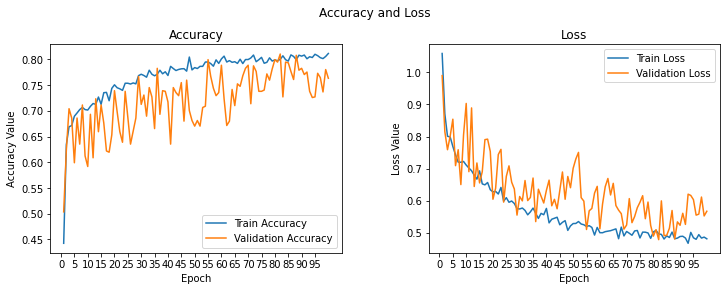

In [16]:
import matplotlib.pyplot as plt
import numpy as np
 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Accuracy and Loss', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = 100
epoch_list = list(range(1,epochs+1))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")
 
ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## Plot Confusion Matrix

In [17]:
TEST_DIR = "/tmp/data/test/"
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size= 1,
    class_mode="categorical",
    color_mode='grayscale',
    shuffle = False,
)

Found 300 images belonging to 3 classes.


In [18]:
import numpy as np

filenames = test_generator.filenames
nb_samples = len(filenames)

predictions = model.predict(test_generator, steps = nb_samples)
y_pred = np.rint(predictions)
y_pred = tf.argmax(y_pred, axis=1)

y_true = test_generator.classes

In [19]:
y_pred

<tf.Tensor: shape=(300,), dtype=int64, numpy=
array([0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0,
       0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
     

In [20]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], d

In [22]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    ##plt.title(title, fontsize=65)
    ##cbar=plt.colorbar()
    ##cbar.ax.tick_params(labelsize=65) 
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=60)
    plt.yticks(tick_marks, classes, fontsize=60)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=60)

    plt.ylabel('True label', fontsize=60)
    plt.xlabel('Predicted label', fontsize=60)

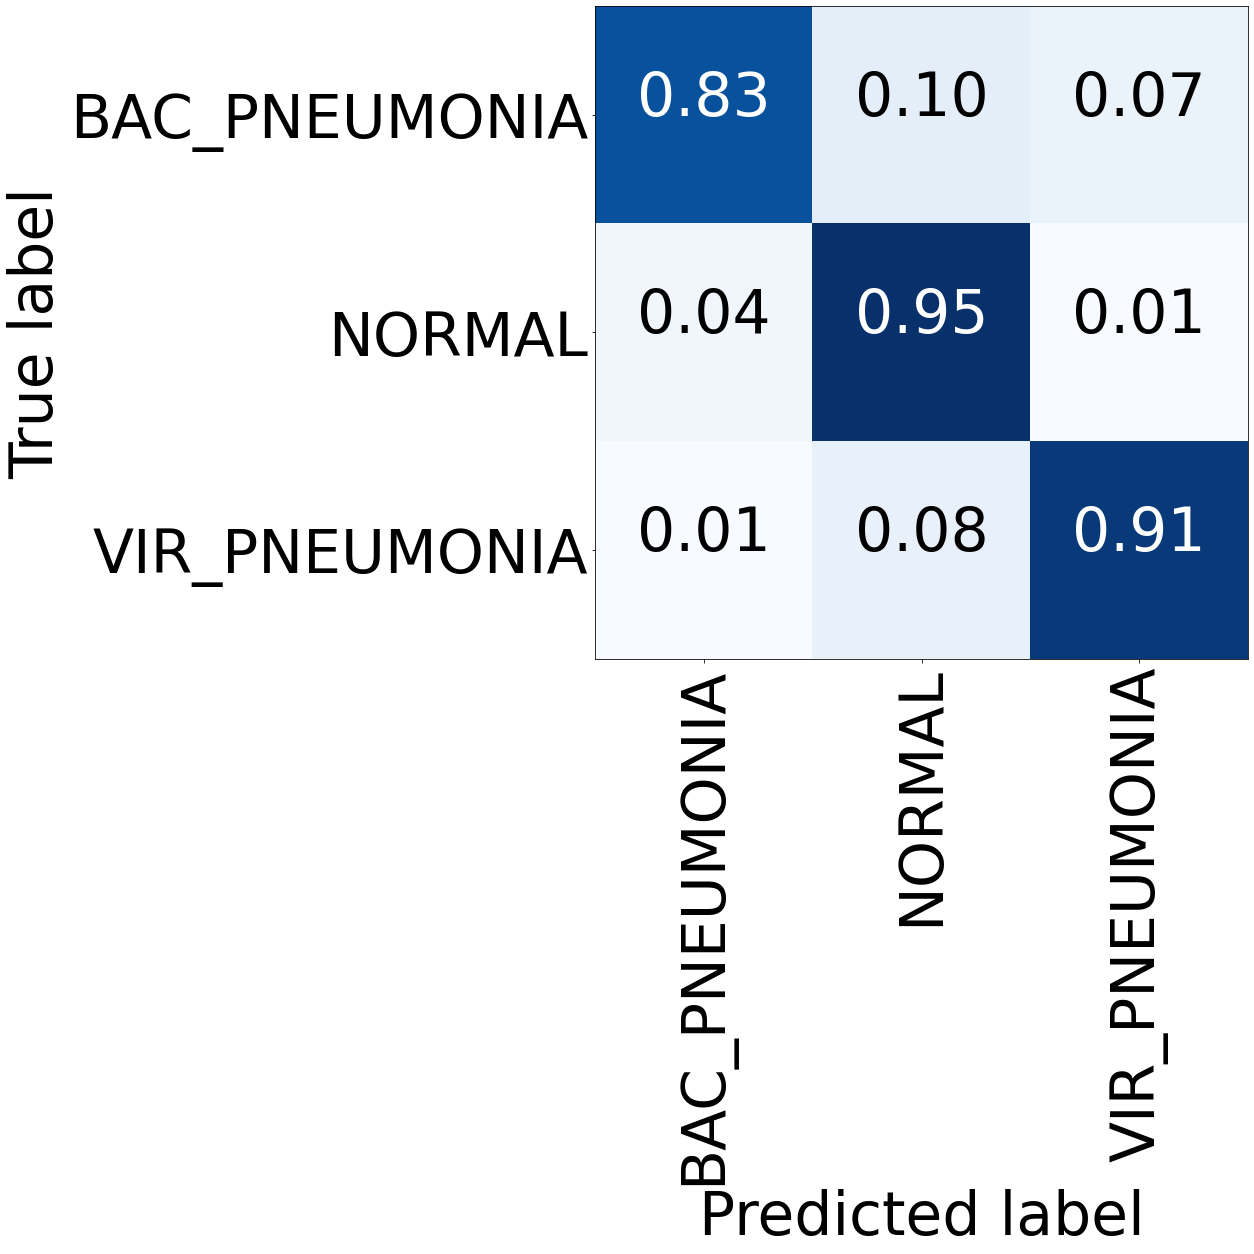

In [23]:
import matplotlib.pyplot as plt

cnf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=validation_generator.class_indices.keys(), title="Confusion matrix")
plt.show()

In [24]:
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.94      0.83      0.88       100
           1       0.84      0.95      0.89       100
           2       0.92      0.91      0.91       100

    accuracy                           0.90       300
   macro avg       0.90      0.90      0.90       300
weighted avg       0.90      0.90      0.90       300



In [25]:
model.evaluate(test_generator)

300/300 [==============================] - 4s 12ms/step - loss: 0.3451 - precision: 0.9094 - recall: 0.8700 - auc: 0.9711 - acc: 0.8967


[0.34509745240211487,
 0.9094076752662659,
 0.8700000047683716,
 0.9711306095123291,
 0.8966666460037231]

## Save Model

In [26]:
model.save('model')

INFO:tensorflow:Assets written to: model/assets


In [27]:
!zip -r /content/cnn_pneumonia_model.zip /content/model/


  adding: content/model/ (stored 0%)
  adding: content/model/keras_metadata.pb (deflated 91%)
  adding: content/model/variables/ (stored 0%)
  adding: content/model/variables/variables.index (deflated 68%)
  adding: content/model/variables/variables.data-00000-of-00001 (deflated 27%)
  adding: content/model/saved_model.pb (deflated 89%)
  adding: content/model/assets/ (stored 0%)


In [28]:
from google.colab import files

files.download("/content/cnn_pneumonia_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Load Model

In [ ]:
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
!sudo apt-get install git-lfs
!git lfs install

Detected operating system as Ubuntu/bionic.
Checking for curl...
Detected curl...
Checking for gpg...
Detected gpg...
Running apt-get update... done.
Installing apt-transport-https... done.
Installing /etc/apt/sources.list.d/github_git-lfs.list...done.
Importing packagecloud gpg key... done.
Running apt-get update... done.

The repository is setup! You can now install packages.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 97 not upgraded.
Need to get 6,229 kB of archives.
After this operation, 14.5 MB of additional disk space will be used.
Get:1 https://packagecloud.io/github/git-lfs/ubuntu bionic/main amd64 git-lfs amd64 2.13.3 [6,229 kB]
Fetched 6,229 kB in 0s (17.6 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/per

In [ ]:
!git clone https://github.com/renardelyon/Pneumonia_detection.git

In [ ]:
import zipfile

with zipfile.ZipFile('/content/Pneumonia_detection/DenseNet/cnn_pneumonia_model.zip', 'r') as zip_ref:
    zip_ref.extractall('/')

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('/content/model')

## Predict

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving bac_pneu.jpeg to bac_pneu.jpeg
Saving normal_lung.jpeg to normal_lung.jpeg
Saving vir_pneu.jpeg to vir_pneu.jpeg


In [ ]:
file_name = []
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
  file_name.append(fn)

User uploaded file "bac_pneu.jpeg" with length 77394 bytes
User uploaded file "normal_lung.jpeg" with length 252680 bytes
User uploaded file "vir_pneu.jpeg" with length 69161 bytes


In [ ]:
import warnings 
warnings.filterwarnings('ignore')
import tensorflow.keras.preprocessing.image as image

def load_image(image_path):
  img = image.load_img(image_path, grayscale=True, target_size=(150, 150, 1))
  plt.imshow(img)
  img_tensor = image.img_to_array(img) 
  img_tensor = np.expand_dims(img_tensor, axis=0)
  img_tensor /= 255. 
  return img_tensor


for file in file_name:
  image_path = '/content/' + file

  try:
    plt.figure()
    
    print(file, 'probability: ', model.predict(load_image(image_path)))
    prediction = model.predict_classes(load_image(image_path))
    
    plt.show()

    if prediction == 0:
      print("It's bacterial pneumonia!\n")
    if prediction == 1:
      print("It's normal!\n")
    if prediction == 2:
      print("It's viral pneumonia!\n")

  except:
    print("Error!")